One of Apache Point Observatory's instruments is the Kitt Peak Ohio State Multi-Object Spectrograph (KOSMOS). This is a long-slit spectrograph attached to a 3.5-meter telescope in New Mexico.

### Loading Data



Searching for files with 'toi3884' tag...
------------------------------------------
toi3884.0033.fits
toi3884.0034.fits
toi3884.0035.fits
toi3884.0036.fits
toi3884.0037.fits


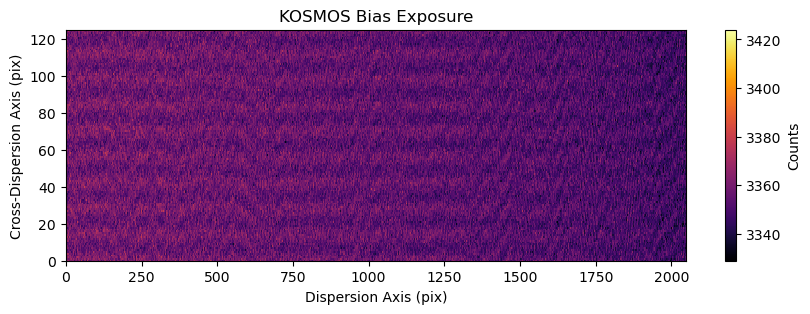

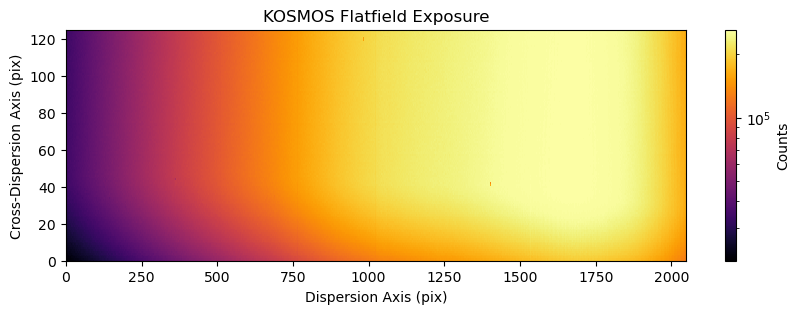

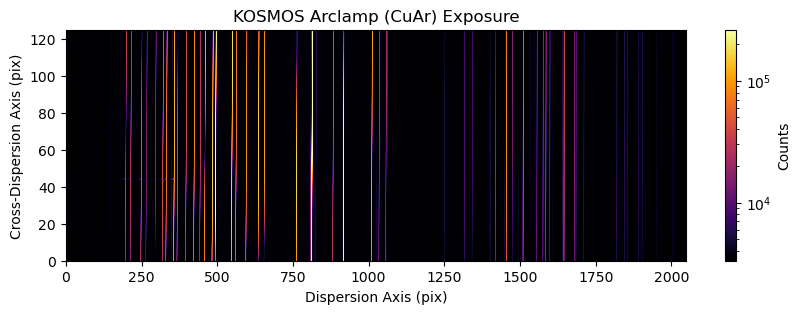

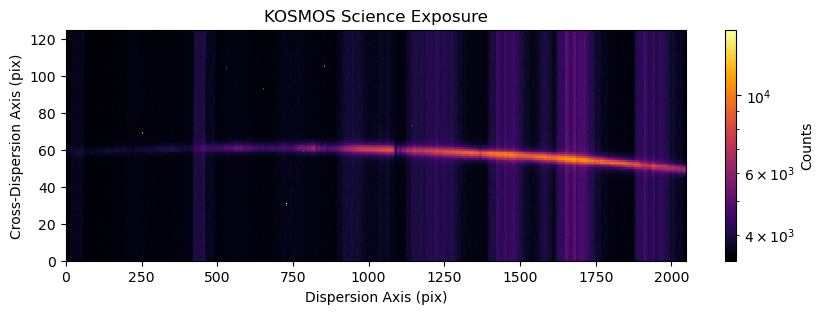

In [38]:
import specsuite as ss

CAL_PATH = "../data/KOSMOS/calibrations"
DATA_PATH = "../data/KOSMOS/target"
DATA_REGION = (175, 300)
#DATA_REGION = (650, 850)

# Loads standard calibration images
bias = ss.average_matching_files(
    path = CAL_PATH,
    tag = "bias",
    instrument = "KOSMOS",
    crop_bds = DATA_REGION,
)

flat = ss.average_matching_files(
    path = CAL_PATH,
    tag = "flat", 
    instrument="KOSMOS",
    crop_bds = DATA_REGION,
)

arc = ss.average_matching_files(
    path = CAL_PATH,
    tag = "neon",
    instrument = "KOSMOS",
    crop_bds = DATA_REGION,
)

# Collects individual science exposures
science = ss.collect_images_array(
    path = DATA_PATH,
    tag = "toi3884",
    instrument = "KOSMOS",
    crop_bds = DATA_REGION,
    debug=True,
).astype(float)

ss.plot_image(bias, title="KOSMOS Bias Exposure")
ss.plot_image(flat, norm='log', title="KOSMOS Flatfield Exposure")
ss.plot_image(arc, norm='log', title="KOSMOS Arclamp (CuAr) Exposure")
ss.plot_image(science[0], norm='log', title="KOSMOS Science Exposure")

(125, 2048)
(125, 2048)
(125, 2048)
(5, 125, 2048)
float64
float64


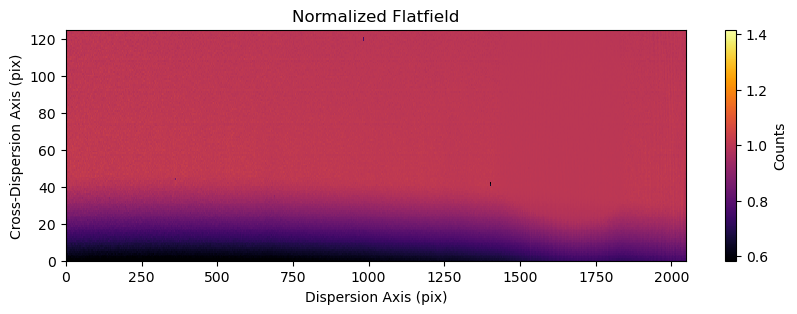

In [ ]:
print(arc.shape)
print(bias.shape)
print(flat.shape)
print(science.shape)

print(bias.dtype)
print(science.dtype)

import numpy as np

# Subtracts off bias from all exposures
arc -= bias
flat -= bias
science -= bias

# # Performs a flatfield correction for all science exposures
# science = ss.flatfield_correction(
#     image = science,
#     flat = flat,
#     debug = True,
# )

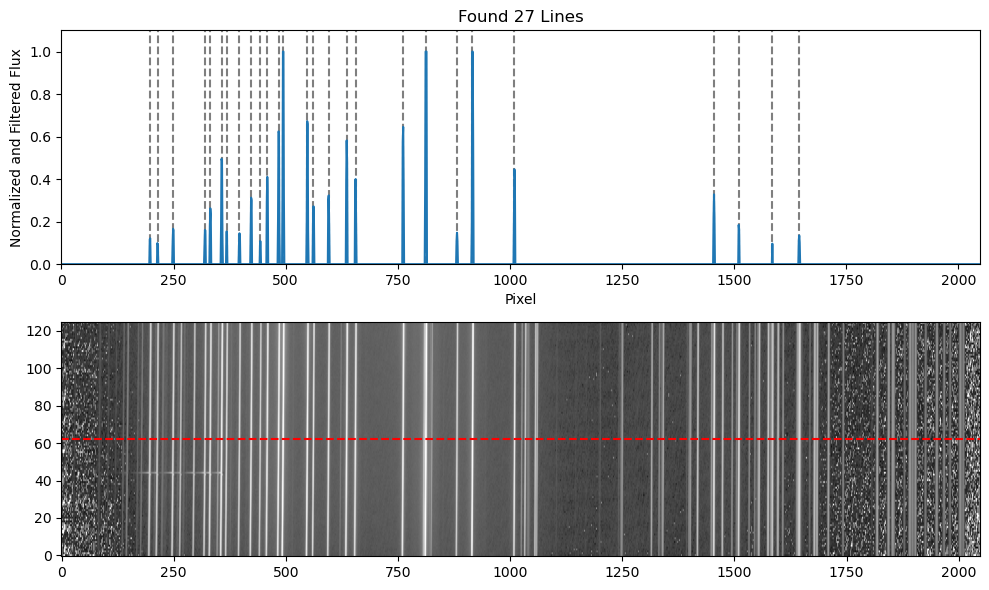

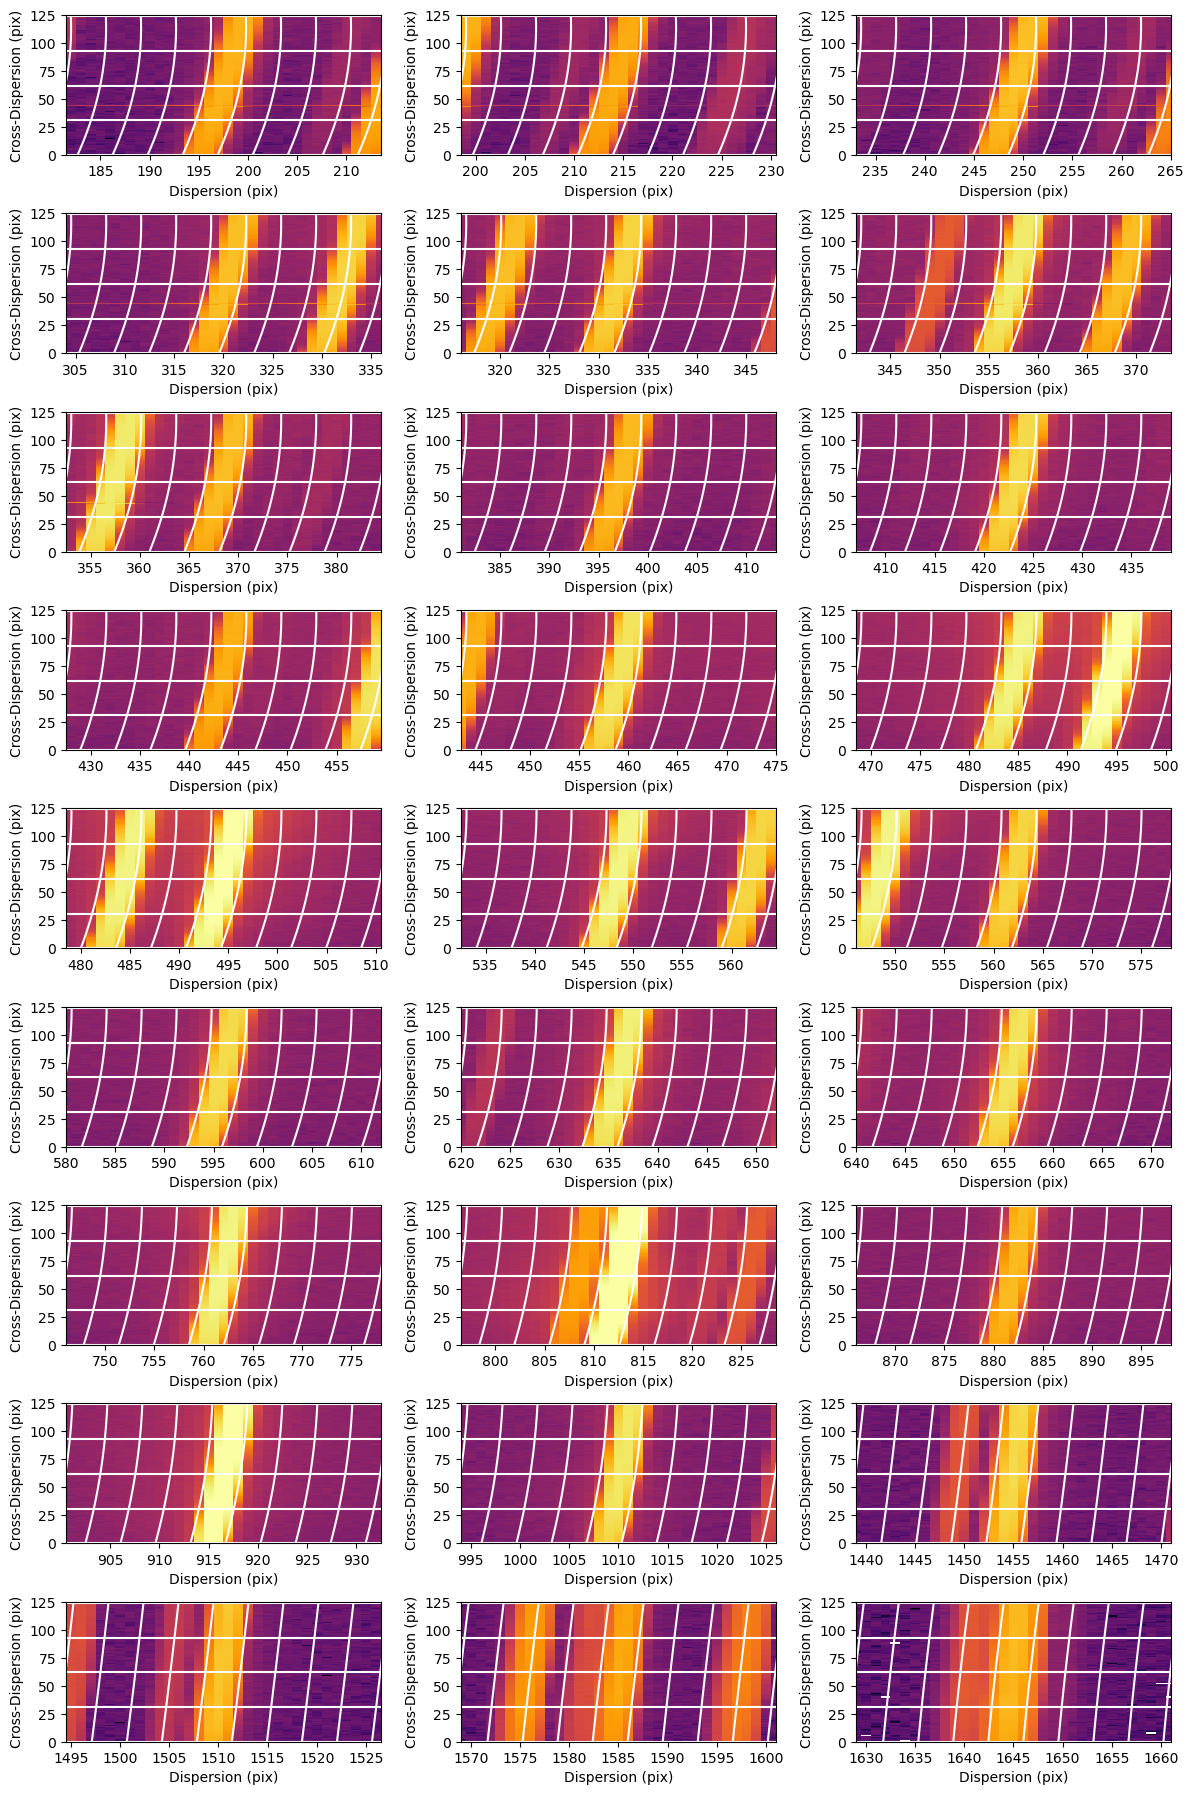

In [40]:
locs, _ = ss.find_cal_lines(
    image = arc,
    std_variation = 250,
    debug = True,
)

warp_model = ss.generate_warp_model(
    image = arc,
    guess = locs,
    debug = True,
)

In [42]:
backgrounds = ss.extract_background(
    images = science,
    warp_model = warp_model,
    mask_region = (40, 80),
    update = True,
)

Extracting Background: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


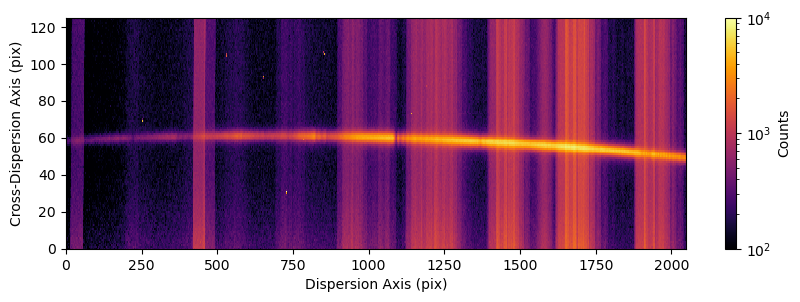

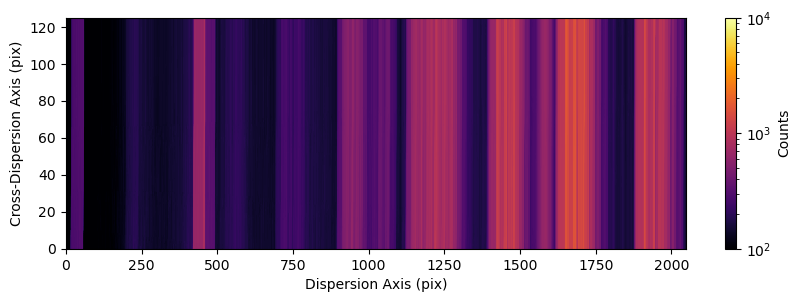

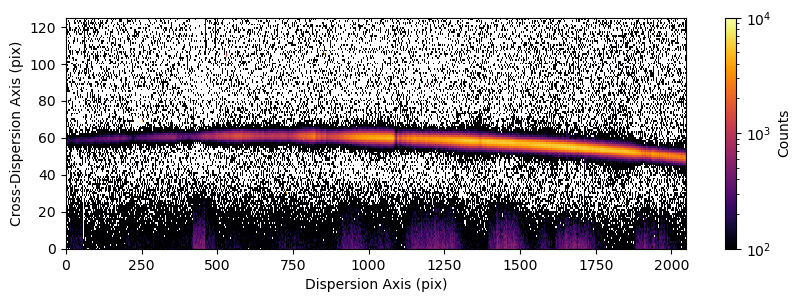

In [43]:
KWARGS = {"vmin": 1e2, "vmax": 1e4}

ss.plot_image(science[0], norm='log', **KWARGS)
ss.plot_image(backgrounds[0], norm='log', **KWARGS)
ss.plot_image(science[0] - backgrounds[0], norm='log', **KWARGS)

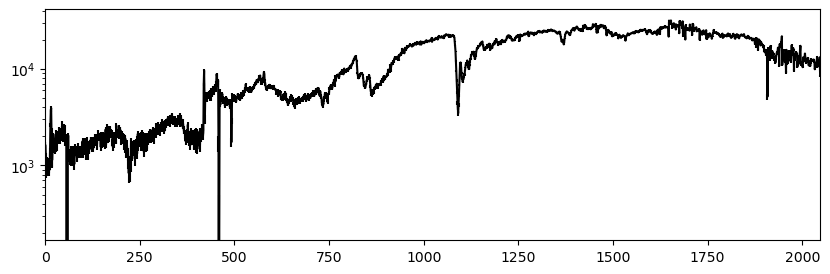

In [44]:
flux, error = ss.boxcar_extraction(
    science = science - backgrounds,
    backgrounds = backgrounds,
    RN = 6.0,
)

boxcar_flux = np.median(flux, axis=0)
boxcar_error = np.max(error, axis=0)

import matplotlib.pyplot as plt

xs = np.array(range(len(boxcar_flux)))
plt.errorbar(xs, boxcar_flux, yerr=boxcar_error, color='k')
plt.xlim(min(xs), max(xs))
plt.yscale("log")
plt.show()